# Uncertainty Quantification for test cases

In [1]:
import os
import shutil

import numpy as np
from scipy.stats import norm,uniform,multivariate_normal

import UQLib.calibration.TMCMC as TMCMC
import test_cases.sinusoidal as sinusoidal
import test_cases.cosine as cosine

import matplotlib.pyplot as plt

np.random.seed(1234)

## Inverse UQ for a cosine function

### Sample from Posterior using TMCMC algorithm

In [2]:
modelpath = "/home/kevin/master_project/IUQ-Project/test_cases/cosine.py"

# Generate data with Gaussian noise
x, y, y_err, true_params = cosine.generate(10,scale=0.1)
a, c, k, f = true_params

# Parameter names
model_params = ["a","c","k","f"]
error_params = ["s"]
design_vars = ["x"]

print("True parameter values:")
print(tuple(model_params), "=")
print((a,c,k,f))

# Design variable values
#design_vals = np.row_stack(np.broadcast(x,a,c))
design_vals = x

# Error parameter per design point
model_errors = ["s" for n in range(x.shape[0])]

# Define uniform prior wrapper functions and samplers for the model parameters
model_func = lambda val: uniform.pdf(val,-5.0,10.0)
model_sampler = lambda n_samples: np.random.uniform(-5.0,5.0,size=n_samples)

# Define prior wrapper function and sampler for the error parameter
error_func = lambda val: uniform.pdf(val,0.001,0.999)
error_sampler = lambda n_samples: np.random.uniform(0.001,1.0,size=n_samples)

model_priors = [(model_func,model_sampler) for param in model_params]
error_priors = [(error_func,error_sampler)]

# Construct problem dict
problem = {"setup":cosine.setup,
           "measure":cosine.read_output,
           "modelpath":modelpath,
           "model parameters":model_params,
           "error parameters":error_params,
           "design variables":design_vars,
           "input data":design_vals,
           "output data":y,
           "data errors":y_err,
           "error mapping":model_errors,
           "model priors":model_priors,
           "error priors":error_priors
          }

os.makedirs("TMCMC_output")
os.chdir("TMCMC_output")

df,qoi = TMCMC.sample(problem,1000,nprocs=8)

os.chdir("..")

# Remove garbage
shutil.rmtree("./TMCMC_output")

print(df)

True parameter values:
('k', 'f') =
(-0.6227226099288554, 2.8535858371376923)
Calculate next p
p: 0.02474270882829291
COV: 1.0000000005116627
Running stage 1...
Current max likelihood: 4.216612788175013e-07
Calculate next p
p: 0.07911027081910782
COV: 0.9999992137230297
Running stage 2...
Current max likelihood: 3.6890727040041903e-06
Calculate next p
p: 0.1760135632778535
COV: 1.0000000009594738
Running stage 3...
Current max likelihood: 3.697375052595525e-06
Calculate next p
p: 0.5042218078690591
COV: 0.9999999999819096
Running stage 4...
Current max likelihood: 6.693630370994156e-06
Calculate next p
p: 0.9999999999999993
COV: 0.800185680060827
Running stage 5...
Current max likelihood: 6.693630370994156e-06
Calculate next p
p: 1.0
COV: 9.106044055070897e-16
Running stage 6...
Current max likelihood: 1.0412015542072164e-05
           k         f         s    likelihood
0  -0.712897  2.428576  0.864271  2.724588e-07
1  -0.752851  2.505684  0.860073  3.843774e-07
2  -0.752851  2.505684

### Propagate uncertainty forward to output

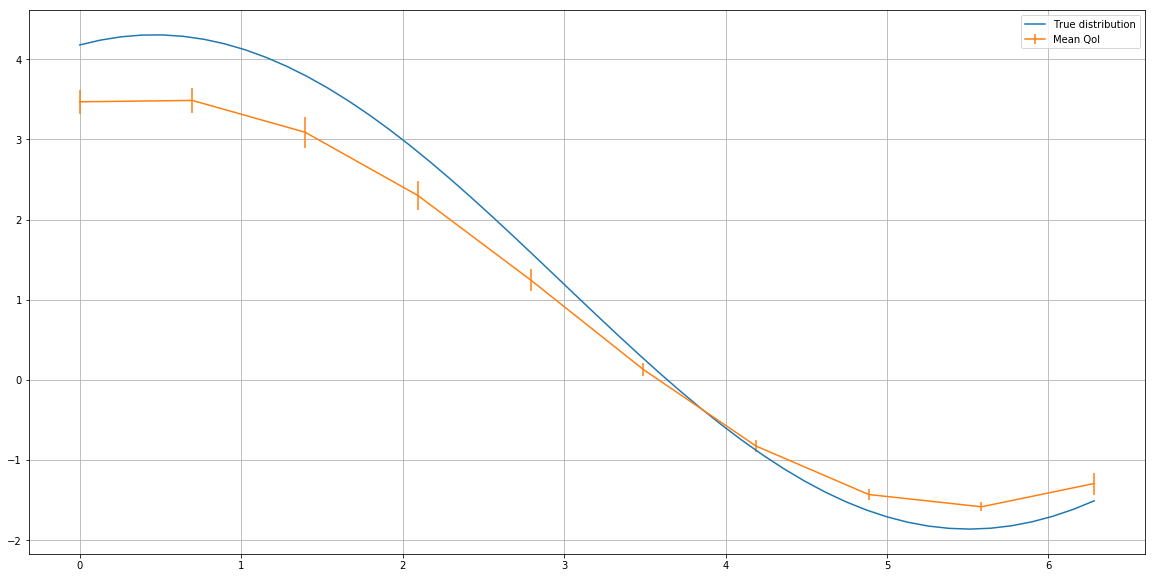

In [6]:
a,c,k,f = true_params

plt.figure(figsize=(20,10))
plt.grid(True)

# Data
#plt.errorbar(x,y,yerr=y_err,label="Data")

# True data
interval = np.linspace(0,2*np.pi)
plt.plot(interval,cosine.evaluate(interval,a,c,k,f),label="True distribution")

# Highest likelihood
mle = np.argmax(df["likelihood"].values)
k,f = df.values[mle,:2]

#plt.plot(x,cosine.evaluate(x,a,c,k,f),label="Max Likelihood Sample")

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

plt.errorbar(x,mean,yerr=conf,label="Mean QoI")

plt.legend()

plt.show()

### Sanity check for output parity

In [4]:
for n in range(qoi.shape[0]):
    k,f = df.values[n,:2]
    remeasure_qoi = cosine.evaluate(x,a,c,k,f)
    if (qoi[n] != remeasure_qoi).any():
        print("Difference:",qoi[n]-remeasure_qoi[n])